In [1]:
import pandas as pd
import plotly.express as px

In [2]:
color_discrete_map = {
    "same_plate": "rgb(213, 94, 0)",
    "different_plates": "rgb(0, 158, 115)",
}

symbol_map = {
    "same_row_or_column": "x",
    "different_rows_and_columns": "circle",
}

In [3]:
orf_genesets = [
    ["SLC39A1", "ZBTB16"],
    ["SARS2", "ECH1", "DGUOK", "MRPS2", "LDHAL6B", "UQCRFS1", "ACADVL", "HMGCL"],
    ["MYT1", "LZTS2", "CHRM4", "GPR176", "TSC22D1", "NEUROD1", "MSC"],
    ["SPDL1", "PAFAH1B1", "NDEL1", "NDE1", "HOOK2", "HOOK1"],
    ["MYT1", "INSYN1", "RNF41", "PAK4", "IKZF1"],
    [
        "ZFP36L1",
        "PIK3R3",
        "NRBP1",
        "INSYN1",
        "HOXC8",
        "RAB40C",
        "RAB40B",
        "HTR1D",
        "TUBA3D",
    ],
    [
        "YAP1",
        "WWTR1",
        "VGLL4",
        "PRKCE",
        "STK3",
        "CEP72",
        "IL20RB",
        "MTMR9",
        "TXNIP",
        "LDLRAD4",
    ],
]

crispr_genesets = [
    ["SLC39A1", "ZBTB16"],
    ["FOXO3", "TGFB1"],
    ["SARS2", "ECH1", "PVR", "LAIR1", "SLC1A5", "UQCRFS1", "CYP3A4", "F2"],
    ["MYT1", "CHRM4", "GPR176", "TSC22D1", "GHRHR", "SCX"],
    ["PIK3R3", "ZFP36L1", "HOXC8", "NRBP1", "RAB40B", "F10", "HTR1B"],
]

In [4]:
well = pd.read_csv("../datasets/metadata/well.csv.gz")

plate = (
    pd.read_csv(
        "../datasets/metadata/plate.csv.gz",
        usecols=["Metadata_Batch", "Metadata_Plate", "Metadata_Source"],
    )
    .query('Metadata_Source == "source_4"')
    .drop(columns="Metadata_Source")
)

metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/orf_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

well_plate_metadata = (
    well.merge(plate, on="Metadata_Plate", how="inner")
    .drop(columns="Metadata_Source")
    .merge(metadata_df, on="Metadata_JCP2022", how="inner")
)

well_plate_metadata.head()

,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_Symbol
0,BR00117035,A01,JCP2022_905588,2021_04_26_Batch1,CDK9
1,BR00117036,A01,JCP2022_905588,2021_04_26_Batch1,CDK9
2,BR00121558,A01,JCP2022_905588,2021_04_26_Batch1,CDK9
3,BR00121559,A01,JCP2022_905588,2021_04_26_Batch1,CDK9
4,BR00121560,A01,JCP2022_905588,2021_04_26_Batch1,CDK9


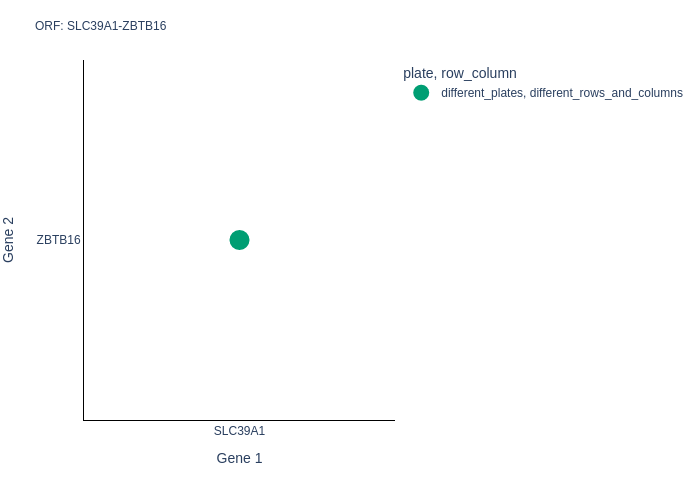

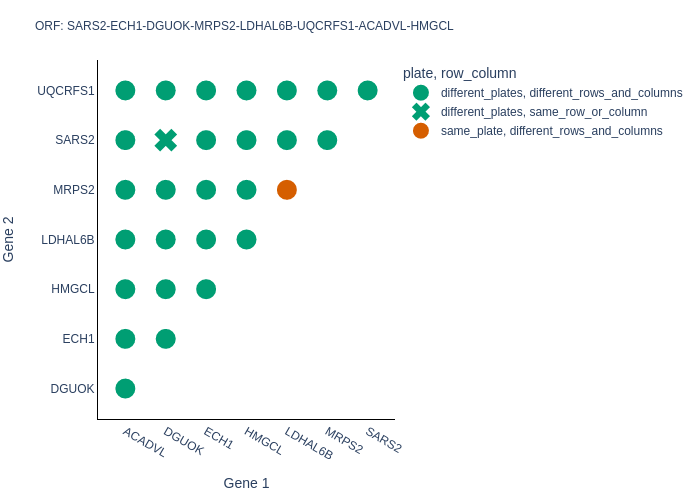

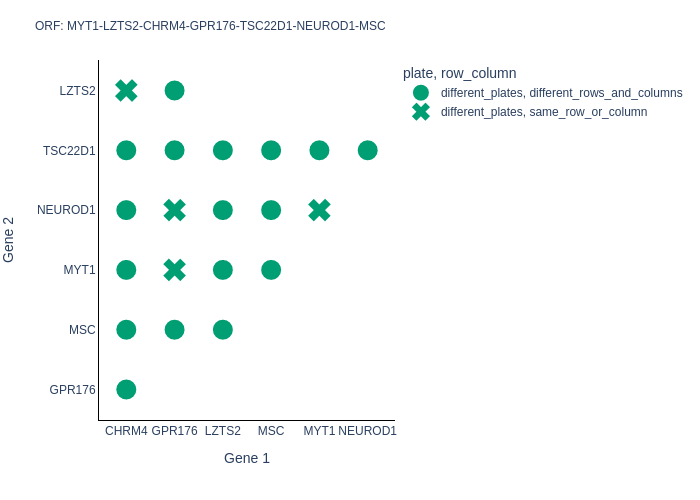

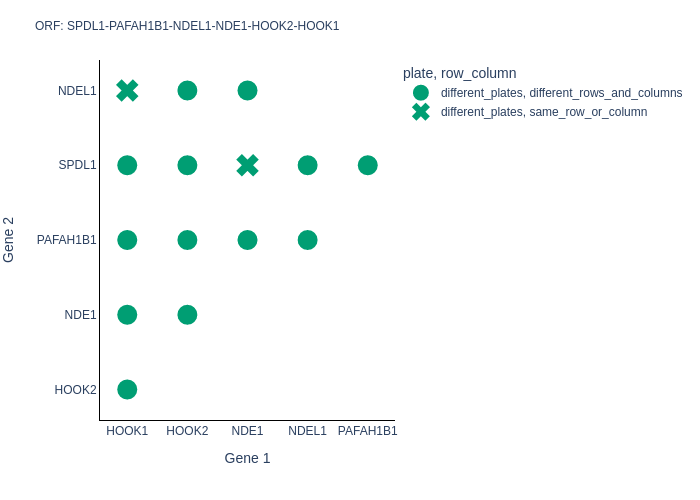

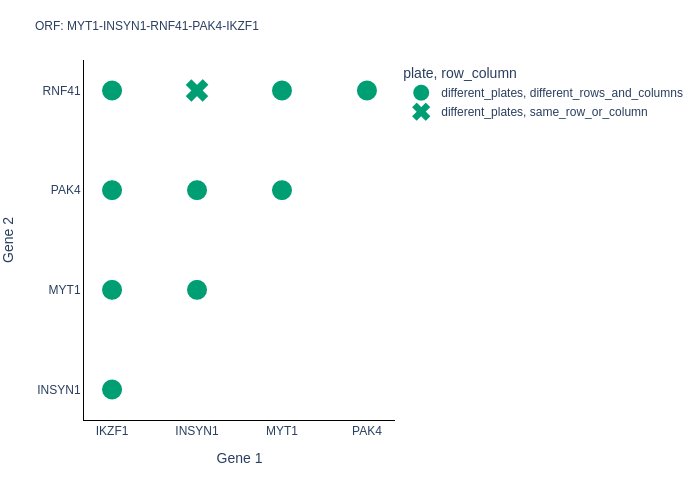

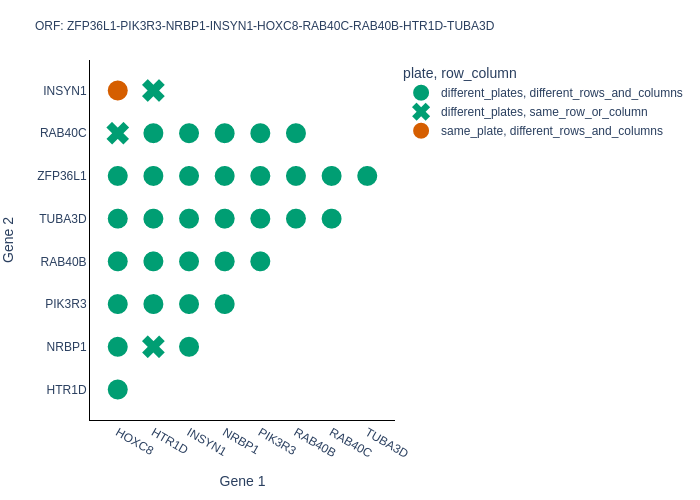

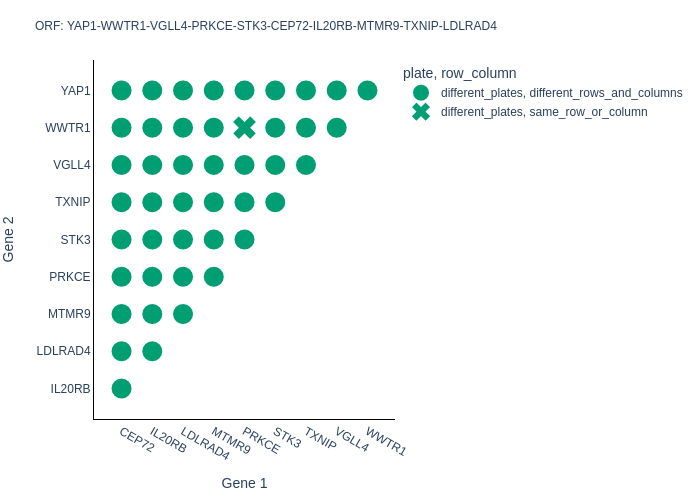

In [5]:
for genes in orf_genesets:
    results = pd.DataFrame()
    df = (
        well_plate_metadata.query("Metadata_Symbol == @genes")
        .sort_values(
            by=["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"], ascending=True
        )[["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"]]
        .drop_duplicates(subset=["Metadata_Symbol"], keep="first")
        .assign(Metadata_Row=lambda x: x["Metadata_Well"].str[0])
        .assign(Metadata_Column=lambda x: x["Metadata_Well"].str[1:])
        .reset_index(drop=True)
    )[["Metadata_Symbol", "Metadata_Plate", "Metadata_Row", "Metadata_Column"]]

    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if df.loc[i, "Metadata_Plate"] == df.loc[j, "Metadata_Plate"]:
                plate = "same_plate"
            else:
                plate = "different_plates"

            if (
                df.loc[i, "Metadata_Row"] == df.loc[j, "Metadata_Row"]
                or df.loc[i, "Metadata_Column"] == df.loc[j, "Metadata_Column"]
            ):
                row_column = "same_row_or_column"
            else:
                row_column = "different_rows_and_columns"

            results = pd.concat(
                [
                    results,
                    pd.DataFrame(
                        {
                            "Gene_1": [df.loc[i, "Metadata_Symbol"]],
                            "Gene_2": [df.loc[j, "Metadata_Symbol"]],
                            "plate": [plate],
                            "row_column": [row_column],
                        }
                    ),
                ],
                ignore_index=True,
            )

    fig = px.scatter(
        results,
        x="Gene_1",
        y="Gene_2",
        color="plate",
        symbol="row_column",
        color_discrete_map=color_discrete_map,
        symbol_map=symbol_map,
    ).update_layout(
        title=dict(text=f"ORF: {'-'.join(genes)}", font=dict(size=12)),
        xaxis=dict(title="Gene 1", linecolor="black"),
        yaxis=dict(title="Gene 2", linecolor="black"),
        plot_bgcolor="white",
    ).update_traces(marker=dict(size=20))

    fig.show("png")
    fig.write_image(f"figures/plate-layout-orf-{'-'.join(genes)}.png", height=480, width=640, scale=2)
    fig.write_image(f"figures/plate-layout-orf-{'-'.join(genes)}.svg", height=480, width=640, scale=2)

In [6]:
well = pd.read_csv("../datasets/metadata/well.csv.gz")

plate = (
    pd.read_csv(
        "../datasets/metadata/plate.csv.gz",
        usecols=["Metadata_Batch", "Metadata_Plate", "Metadata_Source"],
    )
    .query('Metadata_Source == "source_13"')
    .drop(columns="Metadata_Source")
)

metadata_df = pd.read_csv(
    "../00.download-and-process-annotations/output/crispr_metadata.tsv.gz",
    sep="\t",
    usecols=["Metadata_JCP2022", "Metadata_Symbol"],
)

well_plate_metadata = (
    well.merge(plate, on="Metadata_Plate", how="inner")
    .drop(columns="Metadata_Source")
    .merge(metadata_df, on="Metadata_JCP2022", how="inner")
)

well_plate_metadata.head()

,Metadata_Plate,Metadata_Well,Metadata_JCP2022,Metadata_Batch,Metadata_Symbol
0,CP-CC9-R1-01,A02,JCP2022_800002,20220914_Run1,non-targeting
1,CP-CC9-R1-01,C23,JCP2022_800002,20220914_Run1,non-targeting
2,CP-CC9-R1-01,D02,JCP2022_800002,20220914_Run1,non-targeting
3,CP-CC9-R1-01,F23,JCP2022_800002,20220914_Run1,non-targeting
4,CP-CC9-R1-01,G02,JCP2022_800002,20220914_Run1,non-targeting


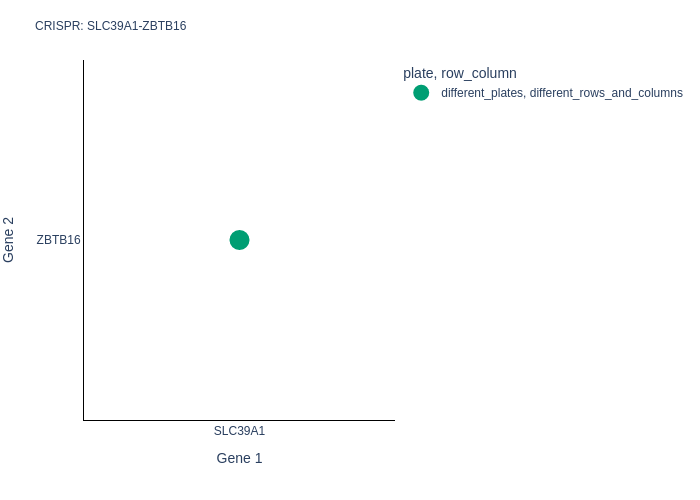

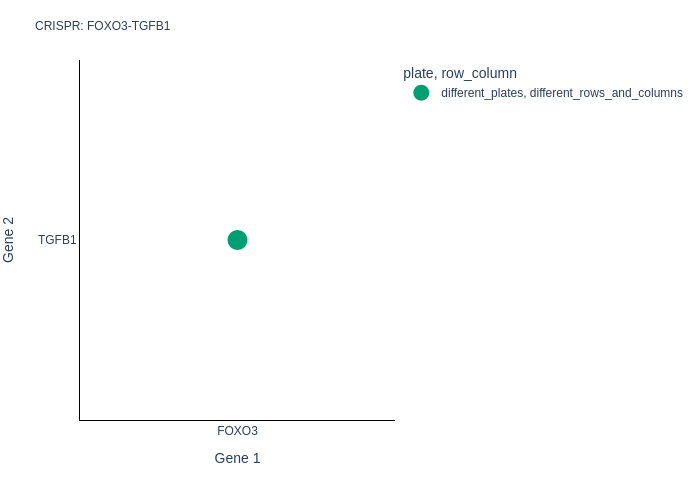

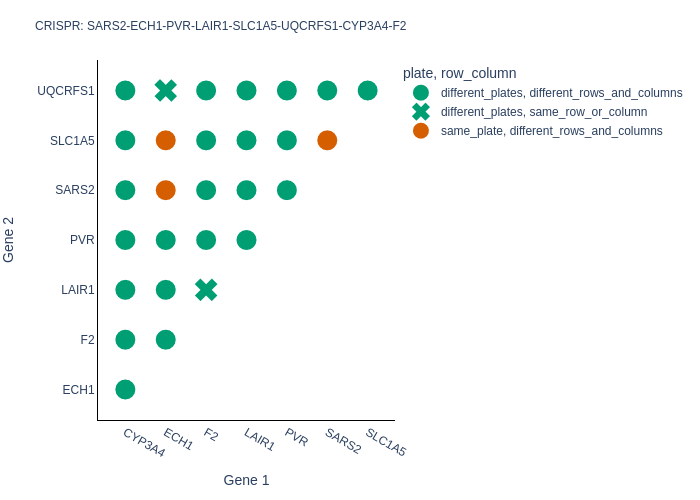

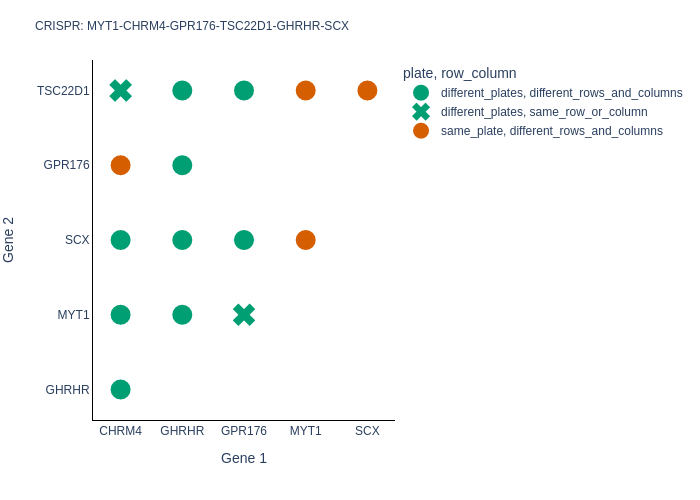

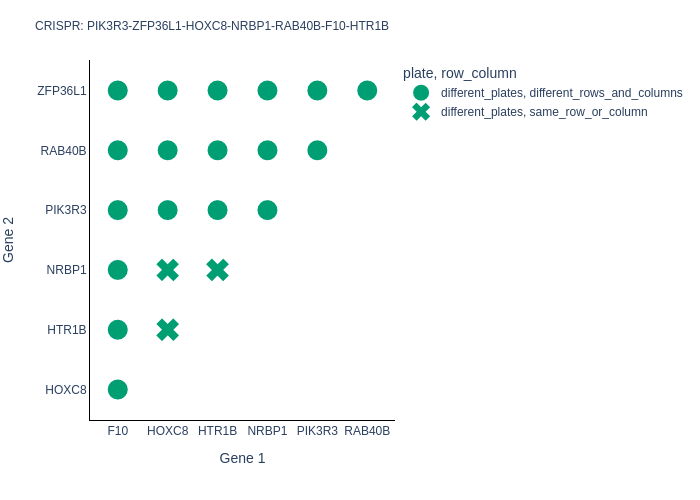

In [7]:
for genes in crispr_genesets:
    results = pd.DataFrame()
    df = (
        well_plate_metadata.query("Metadata_Symbol == @genes")
        .sort_values(
            by=["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"], ascending=True
        )[["Metadata_Symbol", "Metadata_Plate", "Metadata_Well"]]
        .drop_duplicates(subset=["Metadata_Symbol"], keep="first")
        .assign(Metadata_Row=lambda x: x["Metadata_Well"].str[0])
        .assign(Metadata_Column=lambda x: x["Metadata_Well"].str[1:])
        .reset_index(drop=True)
    )[["Metadata_Symbol", "Metadata_Plate", "Metadata_Row", "Metadata_Column"]]

    for i in range(len(df)):
        for j in range(i + 1, len(df)):
            if df.loc[i, "Metadata_Plate"] == df.loc[j, "Metadata_Plate"]:
                plate = "same_plate"
            else:
                plate = "different_plates"

            if (
                df.loc[i, "Metadata_Row"] == df.loc[j, "Metadata_Row"]
                or df.loc[i, "Metadata_Column"] == df.loc[j, "Metadata_Column"]
            ):
                row_column = "same_row_or_column"
            else:
                row_column = "different_rows_and_columns"

            results = pd.concat(
                [
                    results,
                    pd.DataFrame(
                        {
                            "Gene_1": [df.loc[i, "Metadata_Symbol"]],
                            "Gene_2": [df.loc[j, "Metadata_Symbol"]],
                            "plate": [plate],
                            "row_column": [row_column],
                        }
                    ),
                ],
                ignore_index=True,
            )

    fig = px.scatter(
        results,
        x="Gene_1",
        y="Gene_2",
        color="plate",
        symbol="row_column",
        color_discrete_map=color_discrete_map,
        symbol_map=symbol_map,
    ).update_layout(
        title=dict(text=f"CRISPR: {'-'.join(genes)}", font=dict(size=12)),
        xaxis=dict(title="Gene 1", linecolor="black"),
        yaxis=dict(title="Gene 2", linecolor="black"),
        plot_bgcolor="white",
    ).update_traces(marker=dict(size=20))

    fig.show("png")
    fig.write_image(f"figures/plate-layout-crispr-{'-'.join(genes)}.png", height=480, width=640, scale=2)
    fig.write_image(f"figures/plate-layout-crispr-{'-'.join(genes)}.svg", height=480, width=640, scale=2)